🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before). 

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [3]:
#!pip install segmentation-models-pytorch
#!pip install pytorch-lightning==1.5.4


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to c:\users\hp\appdata\local\temp\pip-req-build-iste2gh0
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit b5981e7c2fc0d7def4a16f8c4d17b5a2aca2ad2f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=98733 sha256=73d781078f19ef723a77650c0de1fb72b188a0aab3d05e49abf3546dcead8b42
  Stored in directory: C:\Users\HP\AppData\Local\Temp\pip-ephem-wheel-cache-5q1xznf6\wheels\5b\

  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch 'C:\Users\HP\AppData\Local\Temp\pip-req-build-iste2gh0'


In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

/dss/dsshome1/lxc09/ra49tad2/vit/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [2]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [3]:
# download data
root = "./data_files"
#SimpleOxfordPetDataset.download(root)

In [4]:
# init train, val, test sets
train_dataset = SimpleOxfordPetDataset(root, "train")
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=n_cpu)

Train size: 3312
Valid size: 368
Test size: 3669


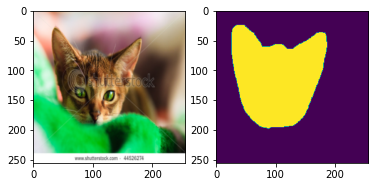

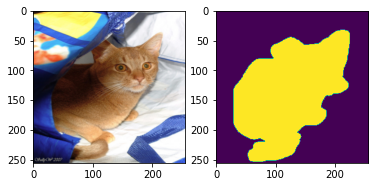

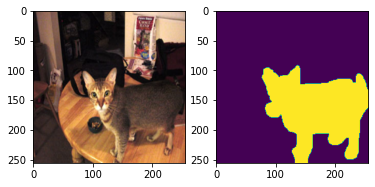

In [5]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [13]:
torch.set_printoptions(profile="full")
print(torch.tensor(sample["mask"]))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Model

In [6]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [12]:
from datasets.segmentation import SegModel
model = SegModel("FPN", "resnet34", in_channels=3, out_classes=1)

1 == 48


/dss/dsshome1/lxc09/ra49tad2/vit/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1 == 48
Load checkpoint at epoch 200


## Training

In [13]:
trainer = pl.Trainer(
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloader=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:733: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
Missing logger folder: c:\Users\HP\Desktop\AppDL\uvcgan\lightning_logs

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

c:\Users\HP\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:686: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [13]:
model.eval()
model.load_state_dict(torch.load(os.path.join('saved_models/cat_models_seg.pth'),map_location=torch.device('cpu')), strict=True)

RuntimeError: Error(s) in loading state_dict for SegModel:
	Missing key(s) in state_dict: "model.encoder.conv1.weight", "model.encoder.bn1.weight", "model.encoder.bn1.bias", "model.encoder.bn1.running_mean", "model.encoder.bn1.running_var", "model.encoder.layer1.0.conv1.weight", "model.encoder.layer1.0.bn1.weight", "model.encoder.layer1.0.bn1.bias", "model.encoder.layer1.0.bn1.running_mean", "model.encoder.layer1.0.bn1.running_var", "model.encoder.layer1.0.conv2.weight", "model.encoder.layer1.0.bn2.weight", "model.encoder.layer1.0.bn2.bias", "model.encoder.layer1.0.bn2.running_mean", "model.encoder.layer1.0.bn2.running_var", "model.encoder.layer1.1.conv1.weight", "model.encoder.layer1.1.bn1.weight", "model.encoder.layer1.1.bn1.bias", "model.encoder.layer1.1.bn1.running_mean", "model.encoder.layer1.1.bn1.running_var", "model.encoder.layer1.1.conv2.weight", "model.encoder.layer1.1.bn2.weight", "model.encoder.layer1.1.bn2.bias", "model.encoder.layer1.1.bn2.running_mean", "model.encoder.layer1.1.bn2.running_var", "model.encoder.layer1.2.conv1.weight", "model.encoder.layer1.2.bn1.weight", "model.encoder.layer1.2.bn1.bias", "model.encoder.layer1.2.bn1.running_mean", "model.encoder.layer1.2.bn1.running_var", "model.encoder.layer1.2.conv2.weight", "model.encoder.layer1.2.bn2.weight", "model.encoder.layer1.2.bn2.bias", "model.encoder.layer1.2.bn2.running_mean", "model.encoder.layer1.2.bn2.running_var", "model.encoder.layer2.0.conv1.weight", "model.encoder.layer2.0.bn1.weight", "model.encoder.layer2.0.bn1.bias", "model.encoder.layer2.0.bn1.running_mean", "model.encoder.layer2.0.bn1.running_var", "model.encoder.layer2.0.conv2.weight", "model.encoder.layer2.0.bn2.weight", "model.encoder.layer2.0.bn2.bias", "model.encoder.layer2.0.bn2.running_mean", "model.encoder.layer2.0.bn2.running_var", "model.encoder.layer2.0.downsample.0.weight", "model.encoder.layer2.0.downsample.1.weight", "model.encoder.layer2.0.downsample.1.bias", "model.encoder.layer2.0.downsample.1.running_mean", "model.encoder.layer2.0.downsample.1.running_var", "model.encoder.layer2.1.conv1.weight", "model.encoder.layer2.1.bn1.weight", "model.encoder.layer2.1.bn1.bias", "model.encoder.layer2.1.bn1.running_mean", "model.encoder.layer2.1.bn1.running_var", "model.encoder.layer2.1.conv2.weight", "model.encoder.layer2.1.bn2.weight", "model.encoder.layer2.1.bn2.bias", "model.encoder.layer2.1.bn2.running_mean", "model.encoder.layer2.1.bn2.running_var", "model.encoder.layer2.2.conv1.weight", "model.encoder.layer2.2.bn1.weight", "model.encoder.layer2.2.bn1.bias", "model.encoder.layer2.2.bn1.running_mean", "model.encoder.layer2.2.bn1.running_var", "model.encoder.layer2.2.conv2.weight", "model.encoder.layer2.2.bn2.weight", "model.encoder.layer2.2.bn2.bias", "model.encoder.layer2.2.bn2.running_mean", "model.encoder.layer2.2.bn2.running_var", "model.encoder.layer2.3.conv1.weight", "model.encoder.layer2.3.bn1.weight", "model.encoder.layer2.3.bn1.bias", "model.encoder.layer2.3.bn1.running_mean", "model.encoder.layer2.3.bn1.running_var", "model.encoder.layer2.3.conv2.weight", "model.encoder.layer2.3.bn2.weight", "model.encoder.layer2.3.bn2.bias", "model.encoder.layer2.3.bn2.running_mean", "model.encoder.layer2.3.bn2.running_var", "model.encoder.layer3.0.conv1.weight", "model.encoder.layer3.0.bn1.weight", "model.encoder.layer3.0.bn1.bias", "model.encoder.layer3.0.bn1.running_mean", "model.encoder.layer3.0.bn1.running_var", "model.encoder.layer3.0.conv2.weight", "model.encoder.layer3.0.bn2.weight", "model.encoder.layer3.0.bn2.bias", "model.encoder.layer3.0.bn2.running_mean", "model.encoder.layer3.0.bn2.running_var", "model.encoder.layer3.0.downsample.0.weight", "model.encoder.layer3.0.downsample.1.weight", "model.encoder.layer3.0.downsample.1.bias", "model.encoder.layer3.0.downsample.1.running_mean", "model.encoder.layer3.0.downsample.1.running_var", "model.encoder.layer3.1.conv1.weight", "model.encoder.layer3.1.bn1.weight", "model.encoder.layer3.1.bn1.bias", "model.encoder.layer3.1.bn1.running_mean", "model.encoder.layer3.1.bn1.running_var", "model.encoder.layer3.1.conv2.weight", "model.encoder.layer3.1.bn2.weight", "model.encoder.layer3.1.bn2.bias", "model.encoder.layer3.1.bn2.running_mean", "model.encoder.layer3.1.bn2.running_var", "model.encoder.layer3.2.conv1.weight", "model.encoder.layer3.2.bn1.weight", "model.encoder.layer3.2.bn1.bias", "model.encoder.layer3.2.bn1.running_mean", "model.encoder.layer3.2.bn1.running_var", "model.encoder.layer3.2.conv2.weight", "model.encoder.layer3.2.bn2.weight", "model.encoder.layer3.2.bn2.bias", "model.encoder.layer3.2.bn2.running_mean", "model.encoder.layer3.2.bn2.running_var", "model.encoder.layer3.3.conv1.weight", "model.encoder.layer3.3.bn1.weight", "model.encoder.layer3.3.bn1.bias", "model.encoder.layer3.3.bn1.running_mean", "model.encoder.layer3.3.bn1.running_var", "model.encoder.layer3.3.conv2.weight", "model.encoder.layer3.3.bn2.weight", "model.encoder.layer3.3.bn2.bias", "model.encoder.layer3.3.bn2.running_mean", "model.encoder.layer3.3.bn2.running_var", "model.encoder.layer3.4.conv1.weight", "model.encoder.layer3.4.bn1.weight", "model.encoder.layer3.4.bn1.bias", "model.encoder.layer3.4.bn1.running_mean", "model.encoder.layer3.4.bn1.running_var", "model.encoder.layer3.4.conv2.weight", "model.encoder.layer3.4.bn2.weight", "model.encoder.layer3.4.bn2.bias", "model.encoder.layer3.4.bn2.running_mean", "model.encoder.layer3.4.bn2.running_var", "model.encoder.layer3.5.conv1.weight", "model.encoder.layer3.5.bn1.weight", "model.encoder.layer3.5.bn1.bias", "model.encoder.layer3.5.bn1.running_mean", "model.encoder.layer3.5.bn1.running_var", "model.encoder.layer3.5.conv2.weight", "model.encoder.layer3.5.bn2.weight", "model.encoder.layer3.5.bn2.bias", "model.encoder.layer3.5.bn2.running_mean", "model.encoder.layer3.5.bn2.running_var", "model.encoder.layer4.0.conv1.weight", "model.encoder.layer4.0.bn1.weight", "model.encoder.layer4.0.bn1.bias", "model.encoder.layer4.0.bn1.running_mean", "model.encoder.layer4.0.bn1.running_var", "model.encoder.layer4.0.conv2.weight", "model.encoder.layer4.0.bn2.weight", "model.encoder.layer4.0.bn2.bias", "model.encoder.layer4.0.bn2.running_mean", "model.encoder.layer4.0.bn2.running_var", "model.encoder.layer4.0.downsample.0.weight", "model.encoder.layer4.0.downsample.1.weight", "model.encoder.layer4.0.downsample.1.bias", "model.encoder.layer4.0.downsample.1.running_mean", "model.encoder.layer4.0.downsample.1.running_var", "model.encoder.layer4.1.conv1.weight", "model.encoder.layer4.1.bn1.weight", "model.encoder.layer4.1.bn1.bias", "model.encoder.layer4.1.bn1.running_mean", "model.encoder.layer4.1.bn1.running_var", "model.encoder.layer4.1.conv2.weight", "model.encoder.layer4.1.bn2.weight", "model.encoder.layer4.1.bn2.bias", "model.encoder.layer4.1.bn2.running_mean", "model.encoder.layer4.1.bn2.running_var", "model.encoder.layer4.2.conv1.weight", "model.encoder.layer4.2.bn1.weight", "model.encoder.layer4.2.bn1.bias", "model.encoder.layer4.2.bn1.running_mean", "model.encoder.layer4.2.bn1.running_var", "model.encoder.layer4.2.conv2.weight", "model.encoder.layer4.2.bn2.weight", "model.encoder.layer4.2.bn2.bias", "model.encoder.layer4.2.bn2.running_mean", "model.encoder.layer4.2.bn2.running_var", "model.decoder.p5.weight", "model.decoder.p5.bias", "model.decoder.p4.skip_conv.weight", "model.decoder.p4.skip_conv.bias", "model.decoder.p3.skip_conv.weight", "model.decoder.p3.skip_conv.bias", "model.decoder.p2.skip_conv.weight", "model.decoder.p2.skip_conv.bias", "model.decoder.seg_blocks.0.block.0.block.0.weight", "model.decoder.seg_blocks.0.block.0.block.1.weight", "model.decoder.seg_blocks.0.block.0.block.1.bias", "model.decoder.seg_blocks.0.block.1.block.0.weight", "model.decoder.seg_blocks.0.block.1.block.1.weight", "model.decoder.seg_blocks.0.block.1.block.1.bias", "model.decoder.seg_blocks.0.block.2.block.0.weight", "model.decoder.seg_blocks.0.block.2.block.1.weight", "model.decoder.seg_blocks.0.block.2.block.1.bias", "model.decoder.seg_blocks.1.block.0.block.0.weight", "model.decoder.seg_blocks.1.block.0.block.1.weight", "model.decoder.seg_blocks.1.block.0.block.1.bias", "model.decoder.seg_blocks.1.block.1.block.0.weight", "model.decoder.seg_blocks.1.block.1.block.1.weight", "model.decoder.seg_blocks.1.block.1.block.1.bias", "model.decoder.seg_blocks.2.block.0.block.0.weight", "model.decoder.seg_blocks.2.block.0.block.1.weight", "model.decoder.seg_blocks.2.block.0.block.1.bias", "model.decoder.seg_blocks.3.block.0.block.0.weight", "model.decoder.seg_blocks.3.block.0.block.1.weight", "model.decoder.seg_blocks.3.block.0.block.1.bias", "model.segmentation_head.0.weight", "model.segmentation_head.0.bias", "gen_ab.net.layer_input.0.weight", "gen_ab.net.layer_input.0.bias", "gen_ab.net.layer_output.weight", "gen_ab.net.layer_output.bias", "gen_ab.net.unet.conv.downsample.weight", "gen_ab.net.unet.conv.downsample.bias", "gen_ab.net.unet.conv.block.block.1.weight", "gen_ab.net.unet.conv.block.block.1.bias", "gen_ab.net.unet.conv.block.block.4.weight", "gen_ab.net.unet.conv.block.block.4.bias", "gen_ab.net.unet.deconv.upsample.1.weight", "gen_ab.net.unet.deconv.upsample.1.bias", "gen_ab.net.unet.deconv.block.block.1.weight", "gen_ab.net.unet.deconv.block.block.1.bias", "gen_ab.net.unet.deconv.block.block.4.weight", "gen_ab.net.unet.deconv.block.block.4.bias", "gen_ab.net.unet.inner_module.conv.downsample.weight", "gen_ab.net.unet.inner_module.conv.downsample.bias", "gen_ab.net.unet.inner_module.conv.block.block.1.weight", "gen_ab.net.unet.inner_module.conv.block.block.1.bias", "gen_ab.net.unet.inner_module.conv.block.block.4.weight", "gen_ab.net.unet.inner_module.conv.block.block.4.bias", "gen_ab.net.unet.inner_module.deconv.upsample.1.weight", "gen_ab.net.unet.inner_module.deconv.upsample.1.bias", "gen_ab.net.unet.inner_module.deconv.block.block.1.weight", "gen_ab.net.unet.inner_module.deconv.block.block.1.bias", "gen_ab.net.unet.inner_module.deconv.block.block.4.weight", "gen_ab.net.unet.inner_module.deconv.block.block.4.bias", "gen_ab.net.unet.inner_module.inner_module.conv.downsample.weight", "gen_ab.net.unet.inner_module.inner_module.conv.downsample.bias", "gen_ab.net.unet.inner_module.inner_module.conv.block.block.1.weight", "gen_ab.net.unet.inner_module.inner_module.conv.block.block.1.bias", "gen_ab.net.unet.inner_module.inner_module.conv.block.block.4.weight", "gen_ab.net.unet.inner_module.inner_module.conv.block.block.4.bias", "gen_ab.net.unet.inner_module.inner_module.deconv.upsample.1.weight", "gen_ab.net.unet.inner_module.inner_module.deconv.upsample.1.bias", "gen_ab.net.unet.inner_module.inner_module.deconv.block.block.1.weight", "gen_ab.net.unet.inner_module.inner_module.deconv.block.block.1.bias", "gen_ab.net.unet.inner_module.inner_module.deconv.block.block.4.weight", "gen_ab.net.unet.inner_module.inner_module.deconv.block.block.4.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.downsample.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.downsample.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.block.block.1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.block.block.1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.block.block.4.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.conv.block.block.4.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.upsample.1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.upsample.1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.block.block.1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.block.block.1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.block.block.4.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.deconv.block.block.4.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.x_const", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.y_const", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.embed.projector.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.embed.projector.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.output.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_input.output.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.0.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.1.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.2.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.3.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.4.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.5.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.6.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.7.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.8.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.9.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.10.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.re_alpha", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.norm1.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.norm1.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.atten.in_proj_weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.atten.in_proj_bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.atten.out_proj.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.atten.out_proj.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.norm2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.norm2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.ffn.net.0.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.ffn.net.0.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.ffn.net.2.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.encoder.encoder.11.ffn.net.2.bias", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_output.weight", "gen_ab.net.unet.inner_module.inner_module.inner_module.inner_module.trans_output.bias". 
	Unexpected key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.bn1.num_batches_tracked", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.bn1.num_batches_tracked", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.bn2.num_batches_tracked", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.bn1.num_batches_tracked", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.bn2.num_batches_tracked", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.bn1.num_batches_tracked", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.bn2.num_batches_tracked", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.bn1.num_batches_tracked", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.bn2.num_batches_tracked", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.0.downsample.1.num_batches_tracked", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.bn1.num_batches_tracked", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.bn2.num_batches_tracked", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.bn1.num_batches_tracked", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.bn2.num_batches_tracked", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.bn1.num_batches_tracked", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.bn2.num_batches_tracked", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.bn1.num_batches_tracked", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.bn2.num_batches_tracked", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.0.downsample.1.num_batches_tracked", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.bn1.num_batches_tracked", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.bn2.num_batches_tracked", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.bn1.num_batches_tracked", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.bn2.num_batches_tracked", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.bn1.num_batches_tracked", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.bn2.num_batches_tracked", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.bn1.num_batches_tracked", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.bn2.num_batches_tracked", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.bn1.num_batches_tracked", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.bn2.num_batches_tracked", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.bn1.num_batches_tracked", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.bn2.num_batches_tracked", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.0.downsample.1.num_batches_tracked", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.bn1.num_batches_tracked", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.bn2.num_batches_tracked", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.bn1.num_batches_tracked", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.bn2.num_batches_tracked", "decoder.p5.weight", "decoder.p5.bias", "decoder.p4.skip_conv.weight", "decoder.p4.skip_conv.bias", "decoder.p3.skip_conv.weight", "decoder.p3.skip_conv.bias", "decoder.p2.skip_conv.weight", "decoder.p2.skip_conv.bias", "decoder.seg_blocks.0.block.0.block.0.weight", "decoder.seg_blocks.0.block.0.block.1.weight", "decoder.seg_blocks.0.block.0.block.1.bias", "decoder.seg_blocks.0.block.1.block.0.weight", "decoder.seg_blocks.0.block.1.block.1.weight", "decoder.seg_blocks.0.block.1.block.1.bias", "decoder.seg_blocks.0.block.2.block.0.weight", "decoder.seg_blocks.0.block.2.block.1.weight", "decoder.seg_blocks.0.block.2.block.1.bias", "decoder.seg_blocks.1.block.0.block.0.weight", "decoder.seg_blocks.1.block.0.block.1.weight", "decoder.seg_blocks.1.block.0.block.1.bias", "decoder.seg_blocks.1.block.1.block.0.weight", "decoder.seg_blocks.1.block.1.block.1.weight", "decoder.seg_blocks.1.block.1.block.1.bias", "decoder.seg_blocks.2.block.0.block.0.weight", "decoder.seg_blocks.2.block.0.block.1.weight", "decoder.seg_blocks.2.block.0.block.1.bias", "decoder.seg_blocks.3.block.0.block.0.weight", "decoder.seg_blocks.3.block.0.block.1.weight", "decoder.seg_blocks.3.block.0.block.1.bias", "segmentation_head.0.weight", "segmentation_head.0.bias". 

: 

## Validation and test metrics

In [11]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.9089741110801697,
  'valid_per_image_iou': 0.9012985229492188}]


In [12]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_dataset_iou': 0.912933886051178,
  'test_per_image_iou': 0.9064497351646423}]


# Result visualization

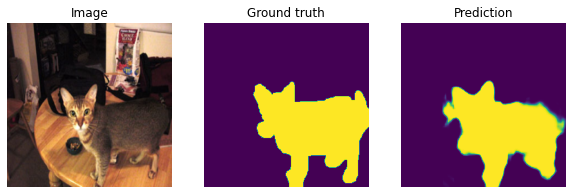

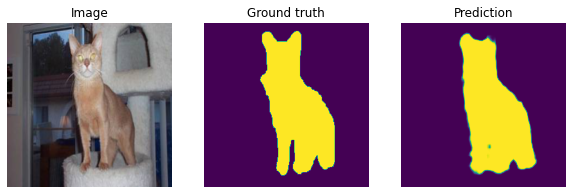

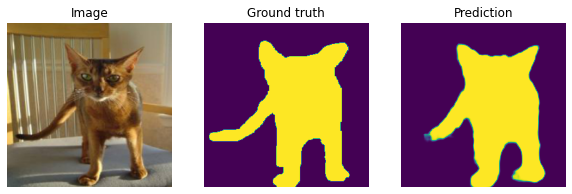

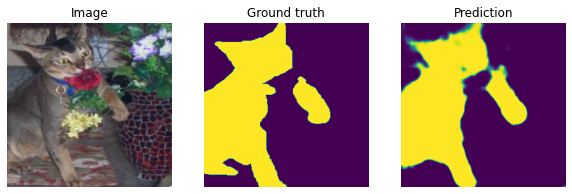

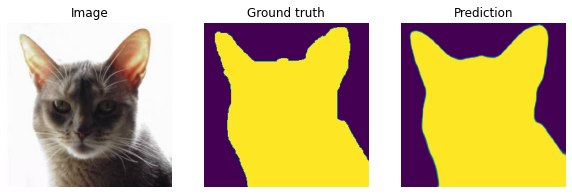

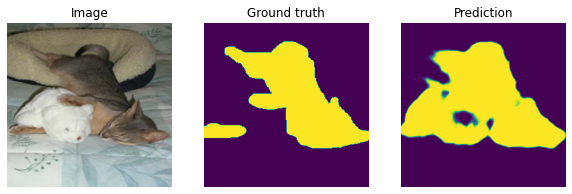

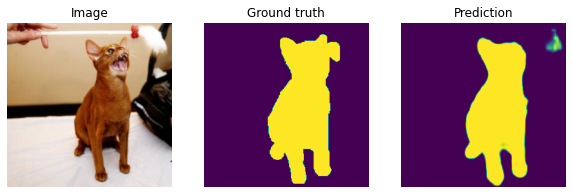

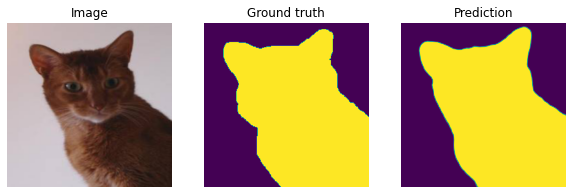

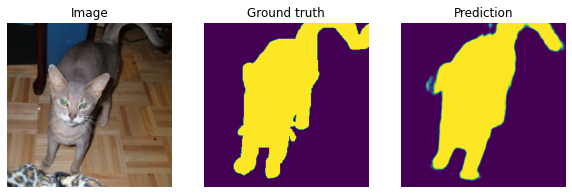

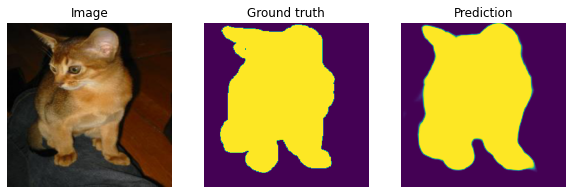

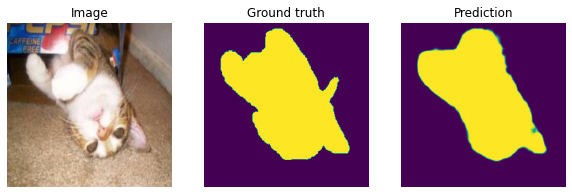

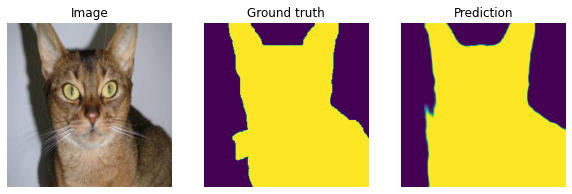

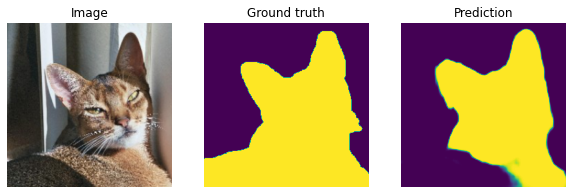

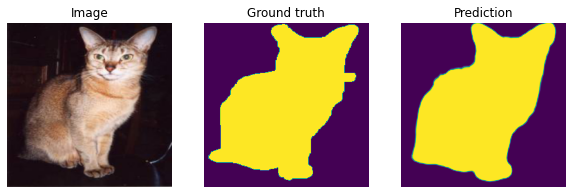

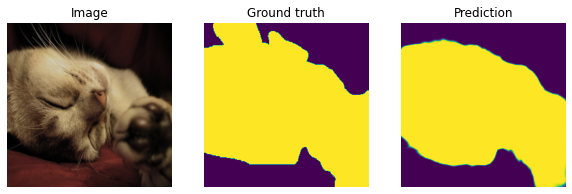

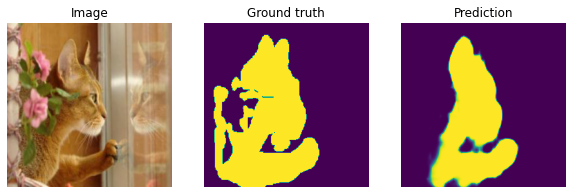

In [13]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()